In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
# fix random seed for reproducibility
np.random.seed(7)

In [85]:
# Import data cell
#  - Creates two dataframes, one for test data and one for training data. 
#  - Add labels two both datasets 
#  - Time countinuos

gear2Path = os.path.normpath('Gear2')
gear3Path = os.path.normpath('Gear3')
gear4Path = os.path.normpath('Gear4')
doublePath = os.path.normpath('Double')
pathList = [gear2Path,gear3Path,gear4Path,doublePath]
classDict = {'Gear2':0,'Gear3':1,'Gear4':2,'Double':3}
dataListR = []
testSetList = []
label = pd.DataFrame()

for p in pathList:
    pPath = os.path.normpath('/Users/mariekorneliusson/documents/AiSports/skate_without_video') + '/' + p
    dirs = os.listdir(pPath)
    for i in range(len(dirs)):    
        tempP = pPath + '/' + dirs[i]
        d = pd.read_csv(tempP,low_memory = False)
        label = pd.DataFrame({'label': classDict[p]*np.ones(len(d),)})
        d = d.join(label)
        if i == 0 :
            testSetList.append(d)
        else:
            dataListR.append(d)

# To get random a random order of segments 
dataOrder = np.random.choice(len(dataListR), size=len(dataListR), replace=False)

# Append segements to one trainingset, and add time sequences to one time countinuos time vector     
skiDataRandom = pd.DataFrame()
addT = 0
for i in dataOrder:
    dataListR[i].t = dataListR[i].t + addT
    addT = dataListR[i].t[len(dataListR[i].t) -1] + 0.02
    skiDataRandom = skiDataRandom.append(dataListR[i]) 

# Append segements to one testset and add time sequences to one time countinuos time vector 
testData = pd.DataFrame()
addT = 0
for i in range(len(testSetList)):
    testSetList[i].t = testSetList[i].t + addT
    addT = testSetList[i].t[len(testSetList[i].t) -1] + 0.02
    testData = testData.append(testSetList[i])

In [86]:
# Change type fro dataframe to ndarray and reshape to fit lstm model.
trainX = skiDataRandom.loc[:,'fL':'a3R'].values
trainY = pd.get_dummies(skiDataRandom['label']).values
testX = testData.loc[:,'fL':'a3R'].values
testY = pd.get_dummies(testData['label']).values

nbrSamples = trainX.shape[0]
nbrSamplesTest = testX.shape[0]
dataDimX = trainX.shape[1]
timesteps = 1
nbrOfClasses = 4

trainX= trainX.reshape(nbrSamples,timesteps,dataDimX)
trainY = trainY.reshape(nbrSamples,timesteps,nbrOfClasses)
testX= testX.reshape(nbrSamplesTest,timesteps,dataDimX)
testY = testY.reshape(nbrSamplesTest,timesteps,nbrOfClasses)

In [92]:
model = Sequential()
model.add(LSTM(256,return_sequences=True,input_shape=(timesteps, dataDimX)))
model.add(Dense(nbrOfClasses, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [93]:
historyFirstModel = model.fit(trainX, trainY, epochs=40, batch_size=100, validation_split=0.2)

Train on 17727 samples, validate on 4432 samples
Epoch 1/40
17727/17727 [==============================] - 5s 273us/step - loss: 0.8190 - categorical_accuracy: 0.6812 - val_loss: 0.7601 - val_categorical_accuracy: 0.6704
Epoch 2/40
17727/17727 [==============================] - 3s 164us/step - loss: 0.5309 - categorical_accuracy: 0.8074 - val_loss: 0.6892 - val_categorical_accuracy: 0.6850
Epoch 3/40
17727/17727 [==============================] - 3s 164us/step - loss: 0.4340 - categorical_accuracy: 0.8462 - val_loss: 0.6371 - val_categorical_accuracy: 0.7349
Epoch 4/40
17727/17727 [==============================] - 3s 165us/step - loss: 0.3776 - categorical_accuracy: 0.8638 - val_loss: 0.6571 - val_categorical_accuracy: 0.7155
Epoch 5/40
17727/17727 [==============================] - 3s 165us/step - loss: 0.3385 - categorical_accuracy: 0.8774 - val_loss: 0.5672 - val_categorical_accuracy: 0.7805
Epoch 6/40
17727/17727 [==============================] - 3s 165us/step - loss: 0.3060 - ca

In [94]:
predY = model.predict(testX)

yTestClass = np.argmax(testY, axis=2)
yPredClass = np.argmax(predY, axis=2)


acc = accuracy_score(yTestClass, yPredClass)
print("Accuracy: %.2f" % acc)

Accuracy: 0.78


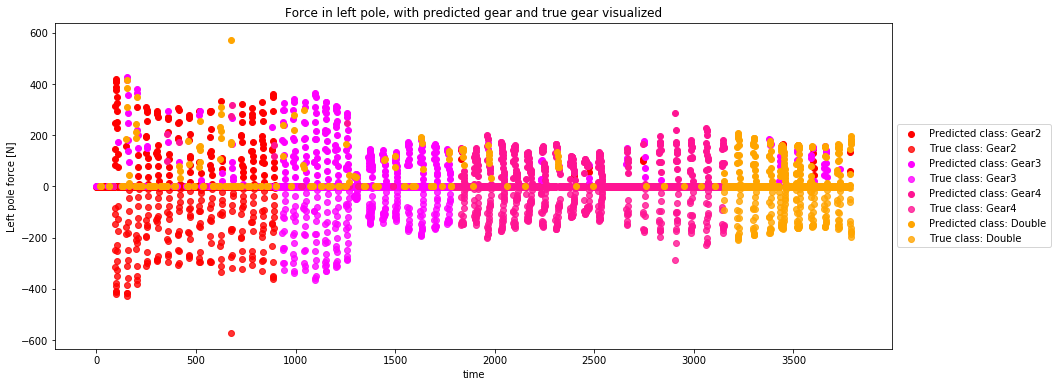

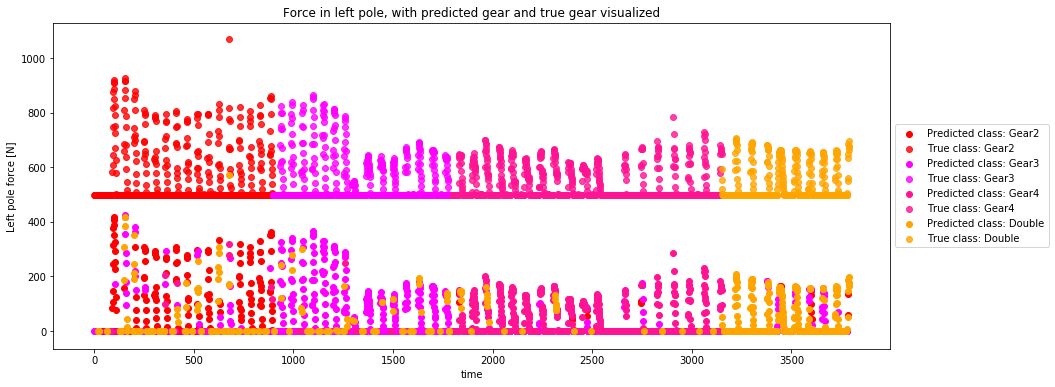

In [95]:
colorDict = {0:'r',1:'fuchsia',2:'deeppink',3:'orange'}
Xplot = X.reshape(nbrSamples,dataDimX)
    
plt.figure(0,figsize=(15, 6))
for c in classDict.keys():
    indClass = np.where(yPredClass == classDict[c])[0][:]
    indCTrue = np.where(yTestClass == classDict[c])[0][:]
    plt.scatter(time[indClass],Xplot[indClass,0],label = 'Predicted class: ' + c,color =  colorDict[classDict[c]], alpha = 1)
    plt.scatter(time[indCTrue],-Xplot[indCTrue,0],label = 'True class: ' + c,color =  colorDict[classDict[c]], alpha = 0.8)
    #plt.fill_between(time[indCTrue], 0, Xplot[indCTrue,0],color = 'red', alpha=0.2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('time')
    plt.ylabel('Left pole force [N]')
    plt.title('Force in left pole, with predicted gear and true gear visualized')
plt.figure(1,figsize=(15, 6))
for c in classDict.keys():
    indClass = np.where(yPredClass == classDict[c])[0][:]
    indCTrue = np.where(yTestClass == classDict[c])[0][:]
    plt.scatter(time[indClass],Xplot[indClass,0],label = 'Predicted class: ' + c,color =  colorDict[classDict[c]], alpha = 1)
    plt.scatter(time[indCTrue],Xplot[indCTrue,0]+500,label = 'True class: ' + c,color =  colorDict[classDict[c]], alpha = 0.8)
    #plt.fill_between(time[indCTrue], 0, Xplot[indCTrue,0],color = 'red', alpha=0.2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('time')
    plt.ylabel('Left pole force [N]')
    plt.title('Force in left pole, with predicted gear and true gear visualized')

In [96]:
# The rows corresponds to predicted of each class and the columns the true of each class.
confusion_matrix(yTestClass, yPredClass)

array([[ 559,  168,   40,  130],
       [  11,  797,   20,   75],
       [  35,  138, 1144,   33],
       [  47,  127,    4,  463]])

Seems like when predictions are made wrong it is most often that the model predicted double. Moreover the results does not implies taht the model is less accurate when the skier change gear. The observation that the model does not have a harder time when changing gear, might be a consequence of the model not taking the past into account as much as one would have liked...